In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf 
import numpy as np 
import pickle
import numpy.random as rng
import matplotlib.pyplot as plt
from scipy.signal import lfilter

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
fo=open('/home/prashanth/cifar-10-batches-py/data_batch_1','rb')
dict=pickle.load(fo,encoding='bytes')
X=dict[b'data']
Y=dict[b'labels']
fo.close
X=X.reshape((len(X),3,32,32)).transpose(0,2,3,1).astype("uint8")
Y=np.array(Y)


In [3]:
def forward_conv(height,width,inshape,outshape,input):
    weights=tf.Variable(rng.randn(height,width,inshape,outshape), dtype = tf.float32,name='conv_weights') #constant
    return(tf.nn.conv2d(input,weights,strides=[1,1,1,1],padding="SAME"))

def forward_pooling_layer(inp,window_size):
    return(tf.nn.max_pool(value=inp,ksize=[1,window_size,window_size,1],strides=[1,1,1,1],padding="SAME"))

def flatten_forward(layer):
    inp_list=layer.get_shape().as_list()
    new_size = inp_list[-1] * inp_list[-2] * inp_list[-3]
    return tf.reshape(layer,[-1,new_size]),new_size

def fc_forward(layer,new_size,no_of_classes):
    weights=tf.Variable(rng.randn(new_size,no_of_classes),dtype=tf.float32,name='fc_forward_weights') #constant
    return tf.matmul(layer,weights)

def fc_fc(rows,columns,layers):
    weights=tf.Variable(rng.randn(rows,columns),dtype=tf.float32,name='fc_fc_weights')
    return tf.matmul(layers,weights)

def activation(layer):
    return tf.nn.relu(layer)

In [5]:
#PARAMETERS
batch=100
iterations=1000
no_of_classes=10

In [6]:
images=tf.placeholder(tf.float32,shape=(batch,32,32,3),name='images')
true_labels=tf.placeholder(tf.float32,shape=(batch,10),name='true_labels')

# Back Prop

In [41]:
# filter_conv_bp=tf.Variable(rng.randn(5,5,3,16), dtype = tf.float32)

#LAYER 1
net_conv_bp= forward_conv(5,5,3,20,images) # height,width,inshape,outshape
net_pool_bp = forward_pooling_layer(net_conv_bp,2) #output,windowsize
net_act_bp=activation(net_pool_bp)

#LAYER2
net_conv_bp2 = forward_conv(5,5,20,50,net_act_bp) # height,width,inshape,outshape
net_pool_bp2 = forward_pooling_layer(net_conv_bp2,2) #output,windowsize
net_act_bp2=activation(net_pool_bp2)

net_flatten_bp,new_size_bp=flatten_forward(net_act_bp2)
net_fc_bp1=fc_forward(net_flatten_bp,new_size_bp,500)
net_act_bp3=activation(net_fc_bp1)
output_bp=fc_fc(500,no_of_classes,net_act_bp3)


e= output_bp-true_labels 

#compute loss
# cost_bp = tf.reduce_sum(tf.pow(e, 2))/2


#cross_entropy_bp=tf.nn.softmax_cross_entropy_with_logits_v2(logits=
#                                  output_bp,labels=true_labels)
cross_entropy_bp=tf.nn.softmax_cross_entropy_with_logits(logits=
                                  output_bp,labels=true_labels)
cost_bp=tf.reduce_mean(cross_entropy_bp)

In [42]:
output_bp

<tf.Tensor 'MatMul_11:0' shape=(100, 10) dtype=float32>

In [43]:
# accuracy_fa=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output,1),tf.argmax(true_labels,1)),tf.float32))
accuracy_bp=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output_bp,1),tf.argmax(true_labels,1)),tf.float32))

In [44]:
# #BP gradients
# bp_grad = tf.gradients(cross_entropy_bp, images)

# override_grad = tf.gradients(cross_entropy, images)

In [48]:
train_op_bp = tf.train.MomentumOptimizer(learning_rate=0.00000001,momentum=0.9).minimize(cost_bp)
# train_op_fa=tf.train.MomentumOptimizer(learning_rate=0.00000001,momentum=0.9).minimize(cross_entropy)

In [49]:
Y_hot=np.eye(10)[Y]
store_err_bp=[]
store_err_fa=[]
acc_fa=[]
acc_bp=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for count in range(iterations):
        batch_no=np.random.randint(0,X.shape[0],size=batch)
        
        inp_features=X[batch_no,:,:,:]
        inp_features=inp_features.astype(np.float32)
    
        inp_labels=Y_hot[batch_no,:]
        inp_labels=inp_labels.astype(np.float32)
    
#         print("Output_bp",sess.run(output_bp,feed_dict={images:inp_features,true_labels:inp_labels}))
#         print("true_labels",inp_labels)
        sess.run(train_op_bp,feed_dict={images:inp_features,true_labels:inp_labels})
             
        entropy_bp=sess.run(cross_entropy_bp,feed_dict={images:inp_features,true_labels:inp_labels})
        store_err_bp.append(np.mean(entropy_bp))
               
        acc_bp.append(sess.run(accuracy_bp,feed_dict={images:inp_features,true_labels:inp_labels}))

        
        if count%100==0:
            print("Iteration:",count)
#             print("Backprop weights:",sess.run(weights))
#             print("Alignment:",np.linalg.norm(autobp_input[0] - override_input[0]))
            print("BackPropagation:",sess.run(cost_bp,feed_dict={images:inp_features,true_labels:inp_labels}))
#         print("error",sess.run(e,feed_dict={images:inp_features,true_labels:inp_labels}))

Iteration: 0
BackPropagation: 24576868.0
Iteration: 100
BackPropagation: 146225.86
Iteration: 200
BackPropagation: 90526.17
Iteration: 300
BackPropagation: 55164.586
Iteration: 400
BackPropagation: 28914.527
Iteration: 500
BackPropagation: 33441.95
Iteration: 600
BackPropagation: 37037.9
Iteration: 700
BackPropagation: 31487.725
Iteration: 800
BackPropagation: 35423.05
Iteration: 900
BackPropagation: 9004.565


In [ ]:
store_err_bp

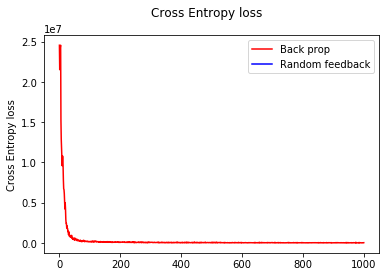

In [50]:
plt.plot(store_err_bp,'r',label='Back prop')
plt.plot(store_err_fa,'b',label='Random feedback')
plt.suptitle('Cross Entropy loss')
plt.ylabel('Cross Entropy loss')
plt.legend()
plt.show()

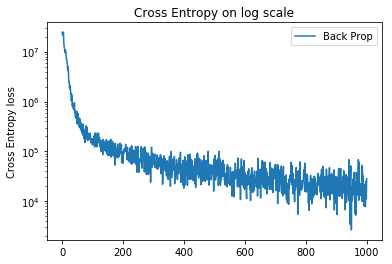

In [51]:
plt.semilogy(store_err_bp,label='Back Prop')

plt.title('Cross Entropy on log scale')
plt.ylabel('Cross Entropy loss')
plt.legend()
plt.show()

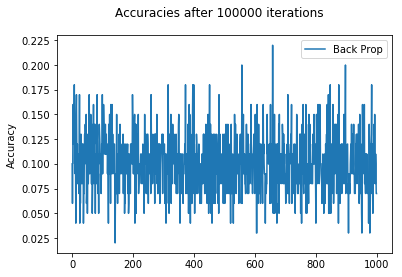

In [52]:
plt.plot(acc_bp,label='Back Prop')
plt.ylabel('Accuracy')
plt.suptitle("Accuracies after 100000 iterations")
plt.legend()
plt.show()

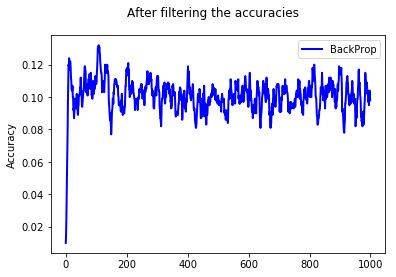

In [53]:
n = 10 # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yy_bp = lfilter(b,a,acc_bp)
# yy_fa = lfilter(b,a,acc_fa)

plt.plot( yy_bp, linewidth=2, linestyle="-", c="b",label='BackProp')

# plt.plot( yy_fa, linewidth=2, linestyle="-", c="g",label='Random Feedback')
plt.suptitle('After filtering the accuracies')
plt.legend()
plt.ylabel('Accuracy')
plt.show()